# Setup

In [1]:
import functools
import matplotlib.pyplot as plt
import numpy as np
import torch
import seaborn as sns

from network import Net, NetDiscovery
from diff_equation import *

DEVICE = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

sns.set_theme()
torch.manual_seed(42)
np.random.seed(10)

# Variables & Training/Equation Data

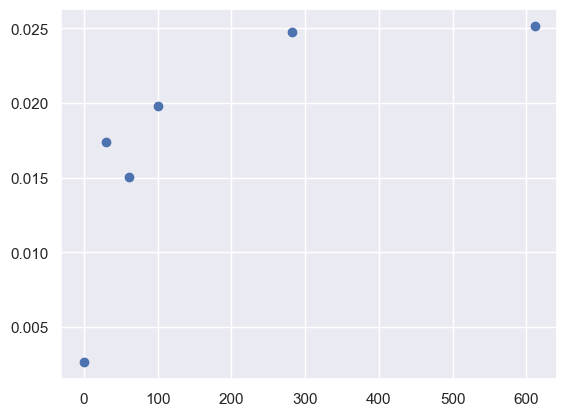

In [2]:
# Different variables for problem
r = 0.001                           # Radius of droplet in [m]
V = (4/3)*np.pi*(r**3)              # Volume of droplet in [m^3]
mu_0 = 1.256637*(10**-6)            # Permeability of free space [m*kg/(s*A)]
eta = 50                            # Viscosity in [Pa*s]
M = magnetization                   # Magnetization in [Oe]
H = magnetic_field                # Magnetic field in [KA/m]
dH_dx = magnetic_field_deriv    # Derivative of magnetic field with respect to distance in [KA/m^2]

t = np.array([0, 30.3468, 60.6936, 100.717, 281.498, 611.498])
x = np.array([0, 0.0159806, 0.0181084, 0.0197945, 0.0234893, 0.0265899])

# Train for 1mm
train_t = t  # Time in (s)
train_x = x + 0.002*np.random.randn(6) # Distance (m)


# Plot training data and equation data
# plt.plot(t, x, 'o')
plt.plot(train_t, train_x, 'o')
# plt.legend(['Equation', 'Training data'])
# plt.ylabel('Position (m)')
# plt.xlabel('Time (s)')

# Physics Loss Model

In [3]:
def physics_loss(model: torch.nn.Module):
    ts = torch.linspace(0, 1200, steps=1200,).view(-1, 1).requires_grad_(True).to(DEVICE)
    xs = model(ts)
    dx = grad(xs, ts)[0]
    pde = (V*M(xs)*mu_0*dH_dx(xs))/(6*r*np.pi*eta) - dx
    
    return torch.mean(pde**2)
    

/Users/christopheragesen/Documents/NJIT/S2025/MATH451/PINNs/pinns-model/src/ferrofluid/diff_equation.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha_tensor = torch.tensor(alpha)


Epoch 0/10000, loss: 314.03
Epoch 1000/10000, loss: 1.00
Epoch 2000/10000, loss: 1.00
Epoch 3000/10000, loss: 1.00
Epoch 4000/10000, loss: 1.00
Epoch 5000/10000, loss: 1.00
Epoch 6000/10000, loss: 1.00
Epoch 7000/10000, loss: 1.00
Epoch 8000/10000, loss: 1.00
Epoch 9000/10000, loss: 1.00


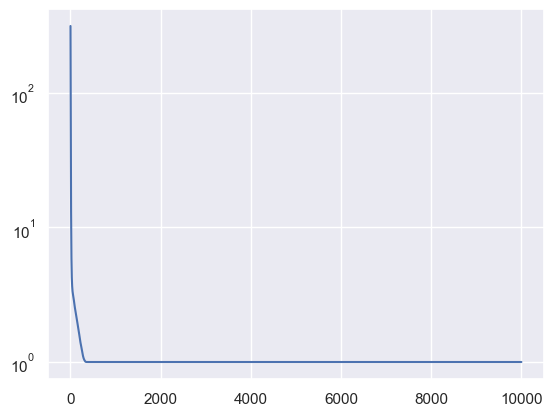

In [4]:
net = Net(1,1, loss2=physics_loss, epochs=10000, loss2_weight=1, lr=1e-5).to(DEVICE)

losses = net.fit(train_t, train_x)
plt.plot(losses)
plt.yscale('log')

Text(0.5, 0, 'Time (s)')

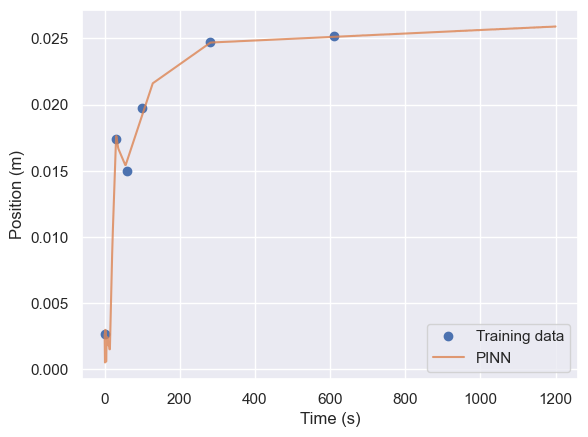

In [5]:
ts = np.linspace(0, 1200, 1200)
preds = net.predict(ts)

plt.plot(train_t, train_x, 'o')
plt.plot(ts, preds, alpha=0.8)
plt.legend(labels=['Training data', 'PINN'])
plt.ylabel('Position (m)')
plt.xlabel('Time (s)')